In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.interpolate import make_interp_spline
from random import random
import numpy as np
import matplotlib.pyplot as plt

# Task 1
I approached the four visualizations by examining four research questions about the data, then attempted to answer them with the visualizations.

### RQ1: Is there such a first-world, second-world, third-world country, with respect to GDP and Gini coefficient?

The existence of a first-world, second-world, and third-world country is predicated on the notion that we may cluster countries together into three distinct groups. For this first visualization, we see if this predication is true. In other words, can countries be neatly clustered into three groups based purely on GDP and Gini coefficient?

In [2]:
df = pd.read_csv('wiid.csv')
filtered = df[(df['quality']=='High') | (df['quality']=='Average')]  # Only get high/average data

Initially, I wanted to filter out data points that were not "high" quality. However, I noticed that this eliminated too many data points. It may also bias the analysis, since countries that have "high" quality data may be more wealthy. We also conduct separate analyses for each 5 year increments. I believe that this is a reasonable increment because of change in productivity due to technology, as well as changes in social policy, etc. 

In [3]:
analyses = []  # each list holds data points for a 5-year analysis
for i in range(filtered.year.min(), filtered.year.max()+1, 5):
    yf = filtered[(filtered.year-5)<i]  # filter data points in five year intervals
    ypoints = []  # store the data points associated with each year
    for country in filtered.country.unique():
        avg_gini = yf[yf.country==country]['gini_reported'].mean()
        avg_gdp = yf[yf.country==country]['gdp_ppp_pc_usd2011'].mean()
        avg_pop = yf[yf.country==country]['population'].mean()
        income_group = yf[yf.country==country]['incomegroup'].mode()
        if pd.isna(avg_gini) or pd.isna(avg_gdp) or pd.isna(avg_pop):  # We do not consider countries that do not have either data point.
            continue
        ypoints.append([avg_gini,avg_gdp,100*avg_pop/yf.population.max(),income_group,country])
    if len(ypoints) == 0:
        continue
    analyses.append([ypoints,i])

Text(0.5, 1.0, 'GDP Per Capita vs. Gini Coefficient')

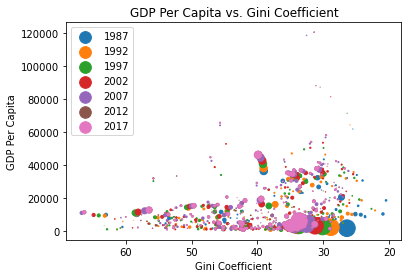

In [4]:
for a,y in analyses:
    plt.scatter([v[0] for v in a],[v[1] for v in a],s=[3*v[2] for v in a],label=y)
    plt.legend()
    plt.gca().invert_xaxis()
plt.xlabel('Gini Coefficient')
plt.ylabel('GDP Per Capita')
plt.title('GDP Per Capita vs. Gini Coefficient')

As we see between various five year peroids, there is little change between the underlying distribution of data points. This in itself probably makes for an interesting analysis on public policy. For some point clusters (which represent the same country), they are crawling toward the top left corner. This may imply that as countries become more "developed" we see higher GDP per capita, but also a higher Gini score (less distribution of wealth). Is this increase in GDP per capita a result of an increase in wealth of all citizens or only those already at the top? This motivates the next question.

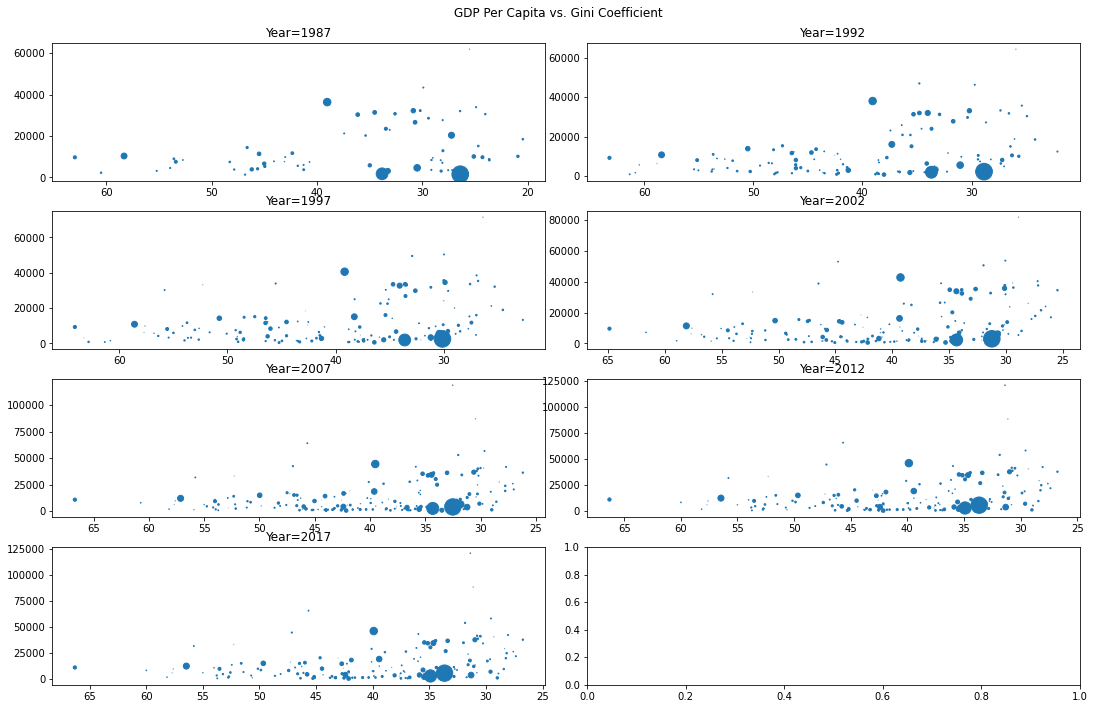

In [5]:
fig,axes = plt.subplots(4,2,figsize=(15,10))
fig.tight_layout()
axes = axes.flatten()
for i,(a,y) in enumerate(analyses):
    axes[i].scatter([v[0] for v in a],[v[1] for v in a],s=[3*v[2] for v in a],)
    axes[i].invert_xaxis()
    axes[i].set_title(f'Year={y}')
fig.suptitle('GDP Per Capita vs. Gini Coefficient')
fig.subplots_adjust(top=0.93)
plt.show()

The points are scaled by relative population. We see that from year to year we cannot make out clear clusters between various countries. We may empircally measure this by running $k$-means clustering such that points are weighted by population, then calculating a silhoutte score. However, in this case it seems trivial. Therefore, we conclude that there is likely no such thing as first-world, second-world, third-world countries w.r.t. gini coefficients and GDP per capita.

### RQ2: What is the general development trajectory (w.r.t. overall wealth and wealth distribution) of "low income", "lower middle income", "upper middle income", and "high income" countries?

In [6]:
df.incomegroup.unique()

array(['Low income', 'Upper middle income', 'High income',
       'Lower middle income'], dtype=object)

We again aggregate the data from each country into 5-year chunks. We then want to plot the derivatives of these chunks. Note that here we are assuming that the income group of a country is invariant in the dataset. Given the "length" of the data set, this may not be a fair assumption. 

In [7]:
analyses = []
for ig in ['Low income', 'Lower middle income','Upper middle income', 'High income', ]:
    igf = df[df.incomegroup == ig]
    incomegroup = []
    for country in igf.country.unique():
        ctr = []
        for i in range(igf.year.min(), igf.year.max()+1,5):
            yfr = igf[(igf.country==country) & (igf.year-5<i)]
            avg_gini = yfr['gini_reported'].mean()
            avg_gdp = yfr['gdp_ppp_pc_usd2011'].mean()
            avg_pop = yfr['population'].mean()
            if pd.isna(avg_gini) or pd.isna(avg_gdp) or pd.isna(avg_pop):
                continue
            ctr.append([avg_gini,avg_gdp,avg_pop])
        incomegroup.append([ctr,country])
    analyses.append(incomegroup)

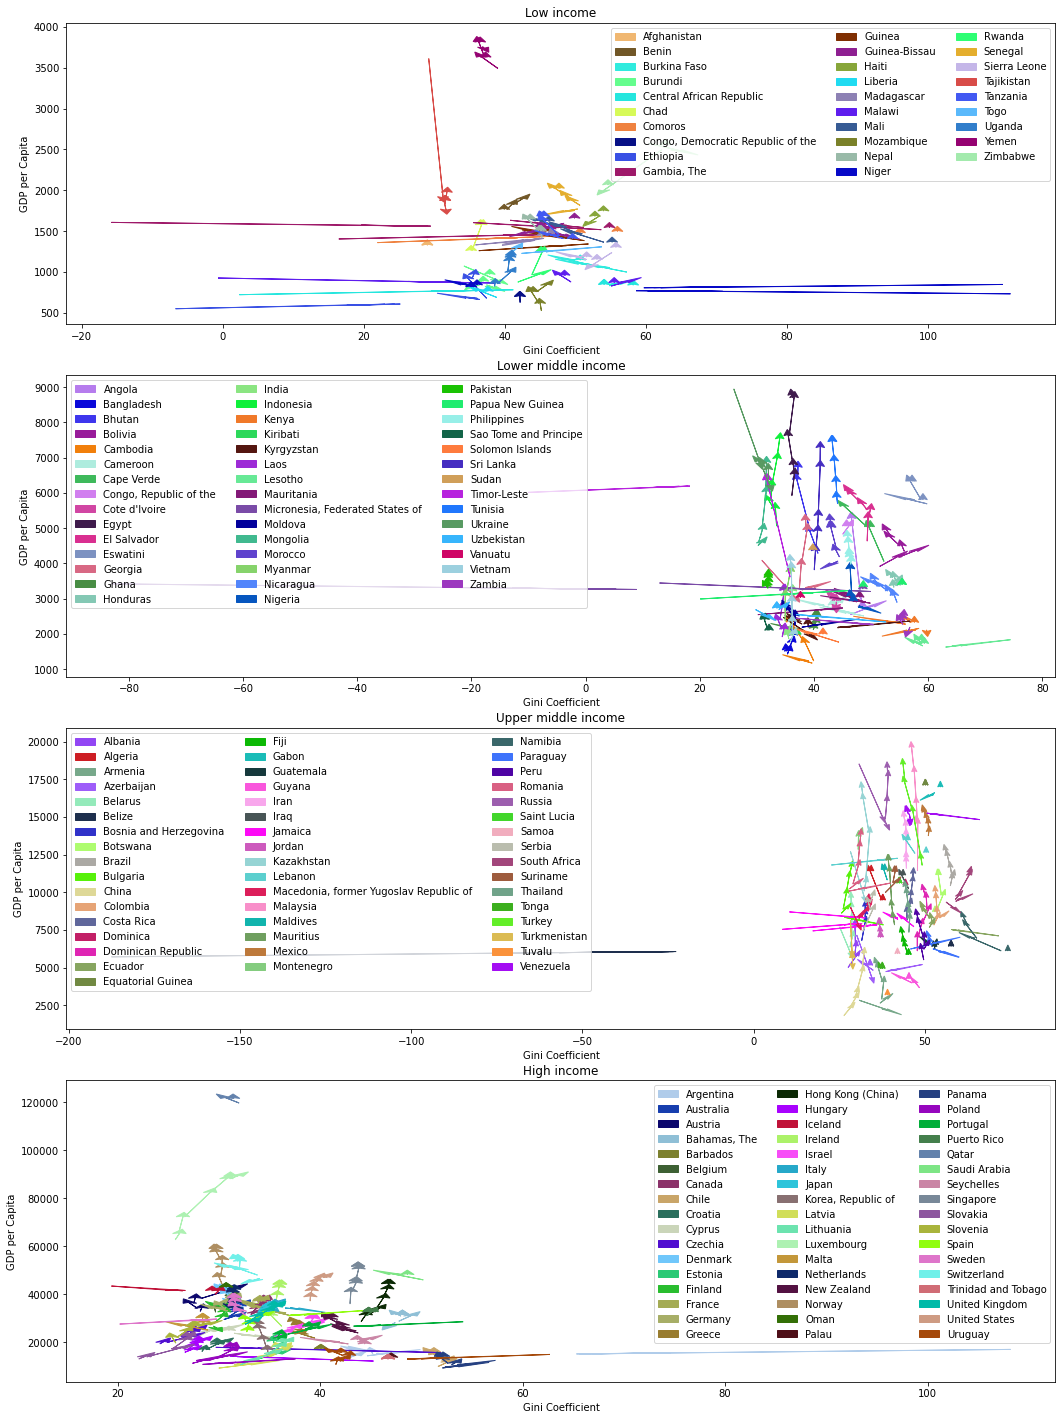

In [8]:
fig,axes = plt.subplots(4,figsize=(15,20))
fig.tight_layout(pad=3.0)
for i,ig in enumerate(['Low income', 'Lower middle income','Upper middle income', 'High income']):
    _maxgdp = df[df.incomegroup==ig]['gdp_ppp_pc_usd2011'].max()
    _maxgii = df[df.incomegroup==ig]['gini_reported'].max()
    for data,country in analyses[i]:
        c = []
        if len(data) == 0: continue
        initial = data[0]
        (r,g,b) = random(), random(), random()
        for j, dp in enumerate(data[1:]):
            c.append(axes[i].arrow(initial[0], initial[1],
                          dp[0] - initial[0],dp[1] - initial[1],
                          width=0.01,head_starts_at_zero=True,label=country if j==0 else "",
                          color=(r,g,b),
                          head_width=_maxgii*0.02, head_length=_maxgdp*0.015,overhang=0.2,))
            initial = data[j+1]
        axes[i].legend(ncol=3)
    axes[i].set_title(ig)
    axes[i].set_xlabel('Gini Coefficient')
    axes[i].set_ylabel('GDP per Capita')
plt.show()

For all four income groups we see that they are primarily increasing in the positive $y$ direction. This implies that GDP per capita is increasing. Notably, we see that for lower middle and upper middle income countries, there is little to no change in Gini coefficient. This suggests that the primary goal for these economies is to increase overall wealth, before trying to implement equality. On the other hand, for high and low income groups, the shifts in the $x$ direction are a lot more apparent. These shifts generally trend to the left (more wealth inequality). This may imply that for high income countries wealth becomes increasingly concentrated at the top, creating a top-down economy. On the other hand, for low income countries, this may represent the prescence of corruption. 

Another interesting observation that can be made from these visualizations is the scale of the arrows. We see that high income countries experience dimish mariginal returns as the economy becomes increasingly saturated. This is similarly observed in low income countries, where it takes wealth to create more wealth. Therefore, the relative magnitude of change is much smaller. On the other hand, for lower middle and upper middle countries they not only have the resources to grow, but they also have much more room to grow. Hence, the large relative magnitudes.

### RQ3: What is the relationship between exchange rate and the wealth held by the first quintile, for low income, lower middle, upper middle, and high income?
In other words, is there a relationship between income inequality and negative trade stability. To quantify this idea of trade stability, I will look at the standard deviation of the exchange rate. High, fluxating exchange rates may imply low trade stability. Whereas a stable exchange rate implies high trade stability.

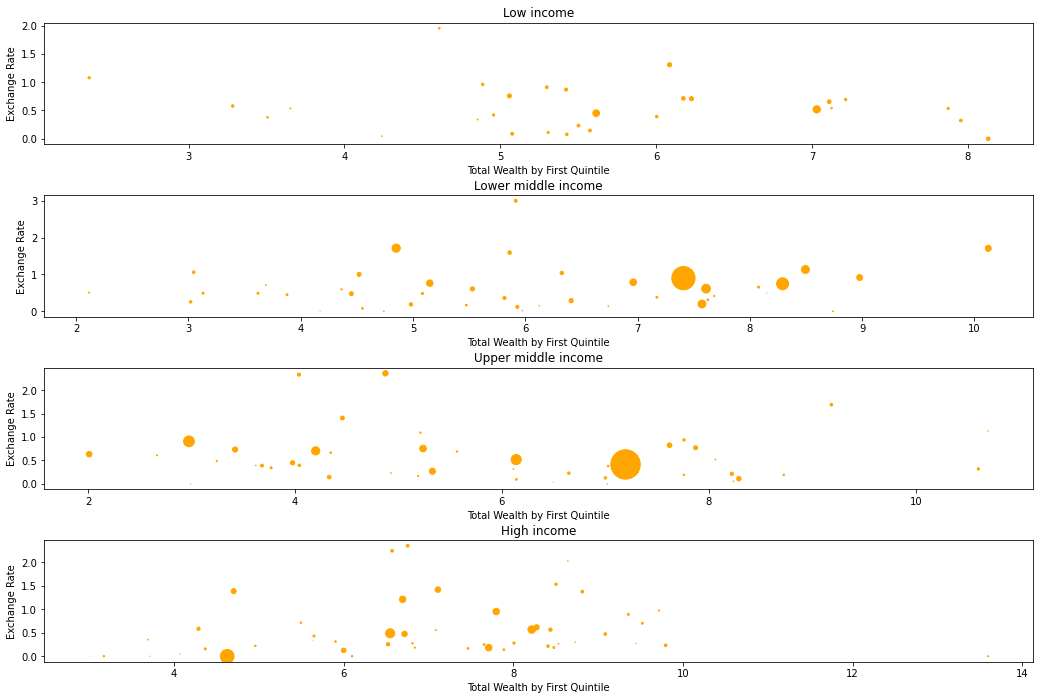

In [9]:
fig,axes = plt.subplots(4, figsize=(15,10))
fig.tight_layout(pad=3)
ctrs = [['Low income', {}], ['Lower middle income', {}], ['Upper middle income', {}], ['High income', {}]]
for i, (ig, d) in enumerate(ctrs):
    for c in df.country.unique():
        cty = df[(df.country==c) & (df.incomegroup == ig) & (df.exchangerate.notna())]
        ex_mean = cty.exchangerate.std() / cty.exchangerate.mean()
        q1_mean = cty.q1.mean()
        q2_mean = cty.q2.mean()
        pop_mean = cty.population.mean()
        if pd.isna(ex_mean) or pd.isna(q1_mean) or pd.isna(pop_mean):
            continue
        d[c] = [ex_mean, q1_mean, pop_mean]
    vs = d.values()
    axes[i].set_title(ig)
    axes[i].set_ylabel('Exchange Rate')
    axes[i].set_xlabel('Total Wealth by First Quintile')
    axes[i].scatter([v[1] for v in vs], [v[0] for v in vs],
                s=[1000*(v[2]/df.population.max()) for v in vs],color='orange')

There is no apparent relationship between these two variables. We do see, for lower middle income countries, there does seem to be an increase in exchange rate standard deviation as first quintile wealth increases. This may suggest that there is a positive relationship for this specific income group (greater income inequality implies greater trade instability). This relationship is also somewhat observed in the high income group as well. I note that here I chose to scale the points by relative population to reduce potential outliers skewing the visualization.

### RQ4: Does globalization reduce or exacerbate income inequality?
We have seen in the news that globalization has displaced low-skill labor jobs. Some economists argue that this phenomenon is beneficial to high income countries as it implies increased job quality which may increase overall wealth. Moreover, it may also allow lower income group countries to industrialize and become more advanced. On the other hand, some economists disagree. They say we may see workers not being able to compete with their counterparts in other countries. They must settle for lower and lower pay with shottier benefits, which may decrease quality of life, leading to increased inequality in income. This question quantatively examines this idea.

Here, we assume that as time increases, globalization will increase. Therefore, time is used as a proxy for globalization.

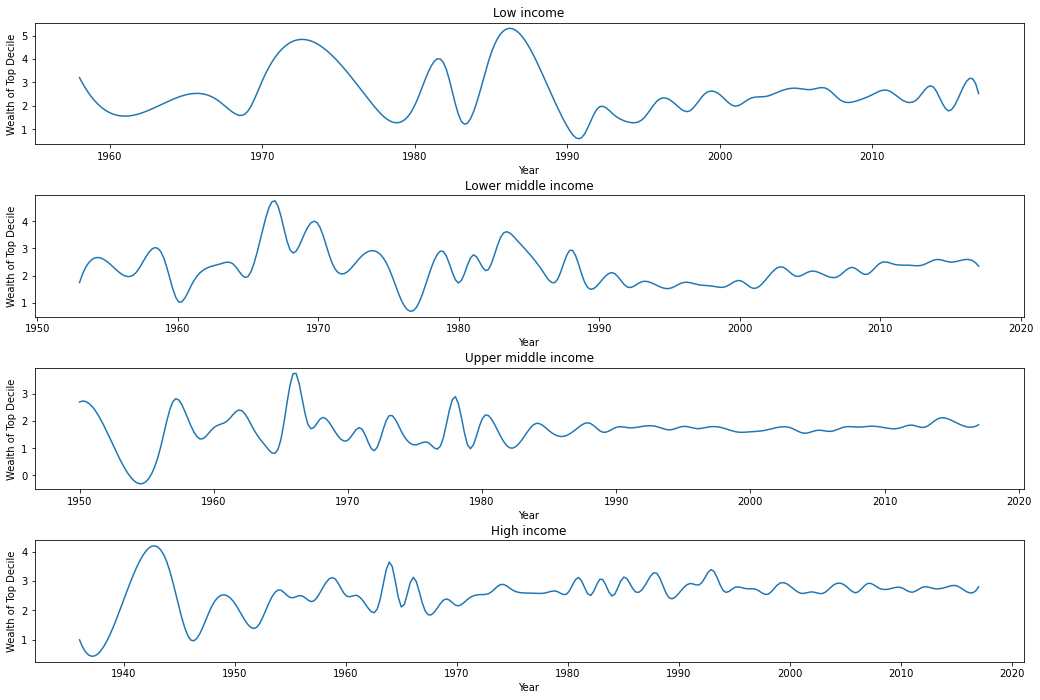

In [10]:
fig,axes = plt.subplots(4, figsize=(15,10))
fig.tight_layout(pad=3)
ig = [['Low income', []], ['Lower middle income', []], ['Upper middle income', []], ['High income', []]]
for i, (icg, l) in enumerate(ig):
    for yr in df.year.unique():
        m = df[(df.incomegroup == icg) & (df.year==yr)].d1.mean()
        if pd.isna(m):
            continue
        ig[i][1].append((yr,m))
        ig[i][1].sort(key=lambda x: x[0])
    x_new = np.linspace(min([v[0] for v in ig[i][1]]), 2017, 300)
    a_BSpline = make_interp_spline([v[0] for v in ig[i][1]], [v[1] for v in ig[i][1]])
    y_new = a_BSpline(x_new)
    axes[i].set_ylabel('Wealth of Top Decile')
    axes[i].set_xlabel('Year')
    axes[i].set_title(icg)
    axes[i].plot(x_new, y_new)

Though we do not see an increase in control of wealthy with an increase in globalization, we do see immense stabilization in all income groups. In other words, it is now much easier to maintain economic status than ever before. Moreover, this may also imply that social structure is a lot more stable, there is less restructuring of societal wealth. I note here that this could also be analyzed for the next nine deciles, which would tell us if societal structure as a whole with respect to wealth is stabilizing or if it is just the top decile. 